https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign

In [25]:
## 1. الإعدادات والتحقق من المسارات

import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from google.colab import drive

# 1. ربط Google Drive
print("جاري ربط Google Drive...")
drive.mount('/content/drive')

# 2. تحديد المسارات الثابتة والمعتمدة
DRIVE_ROOT = '/content/drive/MyDrive'
PROJECT_FOLDER = 'SmartHospital_SkinClinic'
ZIP_FILE_NAME = 'skin_cancer_dataset.zip'
EXTRACT_FOLDER = 'skin_data_clinic_prep'

zip_path = os.path.join(DRIVE_ROOT, PROJECT_FOLDER, ZIP_FILE_NAME)
extract_path = f'/content/{EXTRACT_FOLDER}'

# 3. فك ضغط البيانات
print("\nجاري فك ضغط البيانات...")
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("تم فك ضغط البيانات بنجاح.")
except FileNotFoundError:
    print(f"خطأ: لم يتم العثور على الملف المضغوط في المسار: {zip_path}")

# 4. ضبط المسار النهائي
DATA_DIR = extract_path
train_path = os.path.join(DATA_DIR, 'train')
test_path = os.path.join(DATA_DIR, 'test')

print(f"\nالمسار النهائي المعتمد للبيانات: {DATA_DIR}")

جاري ربط Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

جاري فك ضغط البيانات...
تم فك ضغط البيانات بنجاح.

المسار النهائي المعتمد للبيانات: /content/skin_data_clinic_prep



--- إحصائيات توزيع العينات (للتوثيق في التقرير) ---
     Set      Class  Count
0  TRAIN  malignant   1197
1  TRAIN     benign   1440
2   TEST  malignant    300
3   TEST     benign    360


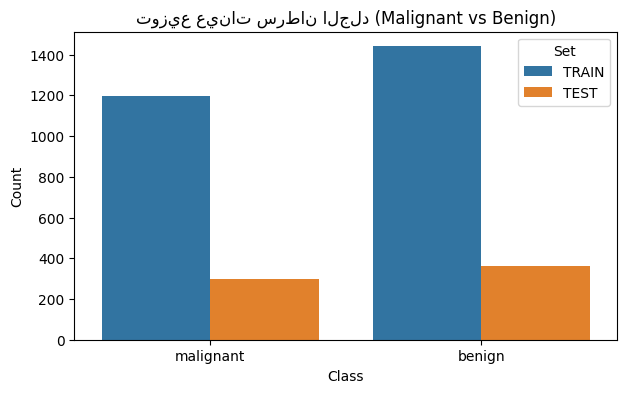

In [26]:
## 2. التحليل الاستكشافي للبيانات (EDA) وإحصائيات التوزيع

# 1. دالة لحساب الإحصائيات (Data Statistics)
def get_data_stats(data_path, subsets=['train', 'test']):
    stats = []
    for subset in subsets:
        for class_name in ['malignant', 'benign']:
            class_path = os.path.join(data_path, subset, class_name)
            if os.path.exists(class_path):
                stats.append({
                    'Set': subset.upper(),
                    'Class': class_name,
                    'Count': len(os.listdir(class_path))
                })
    return pd.DataFrame(stats)

df_stats = get_data_stats(DATA_DIR)
print("\n--- إحصائيات توزيع العينات (للتوثيق في التقرير) ---")
print(df_stats)

# 2. تصور التوزيع (لتحديد مشكلة Data Imbalance)
if not df_stats.empty:
    plt.figure(figsize=(7, 4))
    sns.barplot(data=df_stats, x='Class', y='Count', hue='Set')
    plt.title('(Malignant vs Benign)')
    plt.show()
else:
    print("إطار البيانات فارغ. فشل حساب الإحصائيات.")


--- إحصائيات أبعاد الصور (لتبرير حجم 224x224) ---
       Width  Height
count  800.0   800.0
mean   224.0   224.0
std      0.0     0.0
min    224.0   224.0
25%    224.0   224.0
50%    224.0   224.0
75%    224.0   224.0
max    224.0   224.0


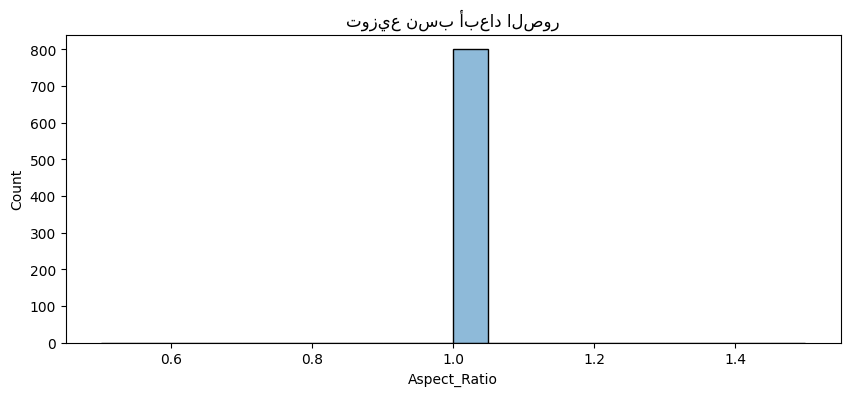

In [27]:
## 3. تحليل خصائص الصور والـ Cleaning الأساسي

def analyze_image_properties(data_path, num_samples=200):
    sizes = []
    # فحص عينات عشوائية
    for subset in ['train', 'test']:
        for class_name in ['malignant', 'benign']:
            class_path = os.path.join(data_path, subset, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                # أخذ عينة عشوائية
                sample_files = np.random.choice(image_files, min(len(image_files), num_samples), replace=False)

                for filename in sample_files:
                    try:
                        img = Image.open(os.path.join(class_path, filename))
                        sizes.append(img.size)
                    except Exception as e:
                        # خطوة Cleaning: تجاهل الملفات التالفة/غير الصالحة
                        print(f"تم تجاهل ملف تالف/غير صالح: {os.path.join(class_path, filename)}")
                        pass

    if sizes:
        df_sizes = pd.DataFrame(sizes, columns=['Width', 'Height'])
        print("\n--- إحصائيات أبعاد الصور (لتبرير حجم 224x224) ---")
        print(df_sizes.describe())

        # رسم توزيع نسب الأبعاد
        df_sizes['Aspect_Ratio'] = df_sizes['Width'] / df_sizes['Height']
        plt.figure(figsize=(10, 4))
        sns.histplot(df_sizes['Aspect_Ratio'], bins=20, kde=True)
        plt.title('توزيع نسب أبعاد الصور')
        plt.show()

analyze_image_properties(DATA_DIR)

In [28]:
## 4. المعالجة المسبقة (Preprocessing) وتضخيم البيانات (Augmentation)

# تحديد الثوابت
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. تضخيم البيانات (Data Augmentation) - للتدريب فقط
# (تقنيات لمكافحة Overfitting وزيادة تنوع بيانات التدريب)
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # 1. التطبيع (Normalization)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# بيانات الاختبار - تطبيع فقط
test_datagen = ImageDataGenerator(rescale=1./255)

# 2. تجهيز الـ Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("\nتم تجهيز Generators البيانات بنجاح.")

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.

تم تجهيز Generators البيانات بنجاح.


In [29]:
## 5. حساب أوزان التصنيفات (Class Weights) لمعالجة الـ Imbalance

# 1. استخراج التصنيفات من Generator التدريب
counter = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# 2. حساب الأوزان العكسية باستخدام sklearn
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(counter),
    y=counter
)

# 3. تحويل الأوزان إلى قاموس يتوافق مع Keras/TensorFlow
class_weights_dict = dict(enumerate(class_weights))

print("\n--- أوزان التصنيفات المُحسوبة (Class Weights) ---")
print(f"التصنيف 0 ({class_labels[0]}): الوزن {class_weights_dict[0]:.3f}")
print(f"التصنيف 1 ({class_labels[1]}): الوزن {class_weights_dict[1]:.3f}")
print("\nسيتم تمرير هذا القاموس (class_weights_dict) إلى دالة model.fit في الملف القادم.")


--- أوزان التصنيفات المُحسوبة (Class Weights) ---
التصنيف 0 (benign): الوزن 0.916
التصنيف 1 (malignant): الوزن 1.102

سيتم تمرير هذا القاموس (class_weights_dict) إلى دالة model.fit في الملف القادم.
